# Deteksi Outlier dengan K-Nearest Neighbors (KNN)

## 1. Mengapa KNN Bisa Digunakan untuk Deteksi Outlier?  
Metode K-Nearest Neighbors (KNN) bekerja dengan prinsip kedekatan antar data, sehingga dapat dimanfaatkan untuk mengidentifikasi outlier. Deteksi outlier menggunakan KNN umumnya didasarkan pada konsep berikut:

* Jika suatu titik data memiliki sedikit tetangga dalam jarak tertentu, kemungkinan besar titik tersebut adalah outlier.
* Jika rata-rata jarak titik data ke k tetangga terdekatnya cukup besar, maka data tersebut dapat dianggap sebagai outlier.

## 2. Langkah-Langkah Deteksi Outlier dengan KNN  
 1. Mengukur Jarak Antar Titik Data  
Jarak antar titik dihitung menggunakan metrik seperti Euclidean Distance, Manhattan Distance, atau Minkowski Distance untuk mengetahui seberapa dekat suatu data dengan yang lainnya.

 2. Menentukan nilai K (Jumlah Tetangga Terdekat)  
Pemilihan nilai K berpengaruh terhadap efektivitas outlier deteksi:
- Nilai K yang terlalu kecil dapat membuat model terlalu sensitif terhadap noise.  
- Nilai K yang terlalu besar bisa menyebabkan outlier tidak terdeteksi dengan baik.  

3. Menghitung Skor Kepadatan (Density Score)  
Beberapa metode untuk menilai apakah suatu titik merupakan outlier meliputi:
  * **K-Nearest Neighbor Distance** - Menghitung jarak rata-rata ke K tetangga terdekat. Jika jarak ini terlalu besar, maka titik tersebut dianggap sebagai outlier.
  * **Local Outlier Factor (LOF)** - Metode ini membandingkan kepadatan lokal suatu titik dengan kepadatan tetangganya. Jika kepadatan lokal suatu titik lebih rendah dibandingkan tetangganya, maka titik tersebut bisa dianggap sebagai outlier.  
  * **Distance-Based Outlier Score** - Jika sebuah titik memiliki jumlah tetangga yang sangat sedikit dalam radius tertentu, maka titik tersebut kemungkinan besar adalah outlier.

In [1]:
%pip install pymysql
%pip install psycopg2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.8 MB/s eta 0:00:00


In [2]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split , KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, Normalizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.naive_bayes import GaussianNB

In [3]:
def get_pg_data():
    conn = psycopg2.connect(
        host="postgresqltest-projectadzin.i.aivencloud.com",
        user="avnadmin",
        password="AVNS_k58rpi0pi31N8ucX-vK",
        database="defaultdb",
        port=16209
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM sepal")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()

    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-386c0068-projectadzin.l.aivencloud.com",
        user="avnadmin",
        password="AVNS_-Zr6_we8osFXobQb3qi",
        database="iris",
        port=16209
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM petal")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()

    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id' dan 'Class'
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
data_values = df_merged[feature_columns].values

In [4]:
# KNN Outlier Detection
def knn_outlier_detection(data, k=90):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    avg_distances = distances[:, -1]  # Ambil jarak k-terjauh sebagai skor
    return avg_distances

# Hitung K-NN distance
df_merged["knn_distance"] = knn_outlier_detection(data_values, k=5)

# Tentukan threshold sebagai nilai rata-rata + 2 standar deviasi
threshold = df_merged["knn_distance"].mean() + 2 * df_merged["knn_distance"].std()
df_merged["outlier_knn"] = df_merged["knn_distance"] > threshold

# Hapus data outlier
df_filtered = df_merged[df_merged["outlier_knn"] != True]

# Cetak hasil setelah outlier dihapus
display(HTML(df_filtered.to_html(index=False)))

print('\n')
num_outliers = df_merged["outlier_knn"].sum()
print(f"Jumlah Outlier: {num_outliers}")

id,class,petal_length,petal_width,sepal_length,sepal_width,knn_distance,outlier_knn
1,Iris-setosa,1.4,0.2,5.1,3.5,0.141421,False
3,Iris-setosa,1.3,0.2,4.7,3.2,0.264575,False
5,Iris-setosa,1.4,0.2,5.0,3.6,0.223607,False
6,Iris-setosa,1.7,0.4,5.4,3.9,0.374166,False
7,Iris-setosa,1.4,0.3,4.6,3.4,0.316228,False
8,Iris-setosa,1.5,0.2,5.0,3.4,0.200000,False
9,Iris-setosa,1.4,0.2,4.4,2.9,0.360555,False
10,Iris-setosa,1.5,0.1,4.9,3.1,0.173205,False
11,Iris-setosa,1.5,0.2,5.4,3.7,0.331662,False
13,Iris-setosa,1.4,0.1,4.8,3.0,0.200000,False




Jumlah Outlier: 15


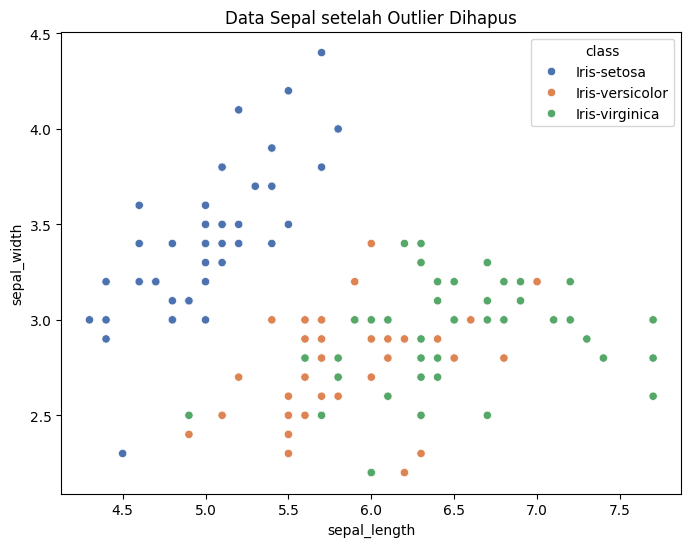

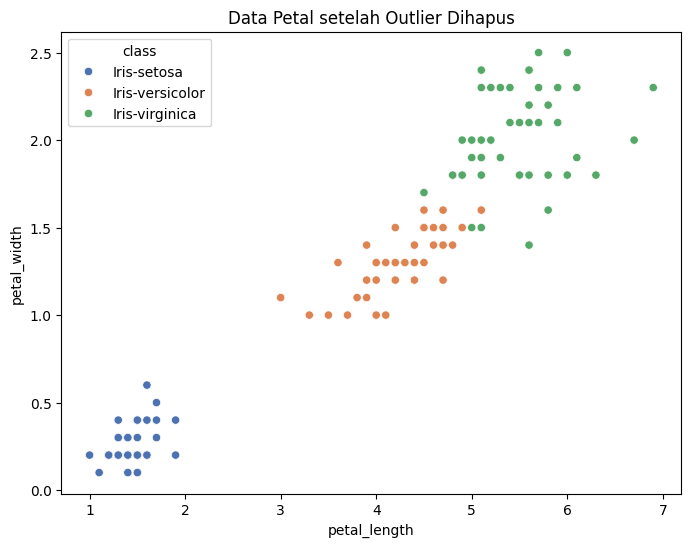

In [5]:
# Visualisasi setelah outlier dihapus
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_filtered["sepal_length"], y=df_filtered["sepal_width"],
    hue=df_filtered["class"], palette="deep"
)
plt.title("Data Sepal setelah Outlier Dihapus")
plt.show()
print('\n')
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_filtered["petal_length"], y=df_filtered["petal_width"],
    hue=df_filtered["class"], palette="deep"
)
plt.title("Data Petal setelah Outlier Dihapus")
plt.show()

## **Memisahkan outlier dari data**

In [6]:
# Gabungkan berdasarkan kolom 'id' dan 'class'
df_merge = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik tanpa kolom 'class'
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
data_values = df_merge[feature_columns].values

# Inisialisasi model LOF
clf = LocalOutlierFactor(n_neighbors=90)
label = clf.fit_predict(data_values)

# Tambahkan hasil label ke dataframe
df_merge["outlier_label"] = label

# Cetak hasil dengan ID dan class
display(HTML(df_merge.to_html(index=False)))

num_outliers = (label == -1).sum()
print(f"\nJumlah outlier: {num_outliers}")
df_filtered = df_merge[label == 1].drop(columns=["outlier_label"], errors='ignore')
outliers = df_merge[label == -1].drop(columns=["outlier_label"], errors='ignore')
print("\nData Outlier:")
display(HTML(outliers.to_html(index=False)))
print("\nJumlah data setelah dihapus : ",len(df_filtered))
print("\nData tidak outlier :")
display(HTML(df_filtered.to_html(index=False)))

id,class,petal_length,petal_width,sepal_length,sepal_width,outlier_label
1,Iris-setosa,1.4,0.2,5.1,3.5,1
2,Iris-setosa,14.0,2.0,40.9,30.0,-1
3,Iris-setosa,1.3,0.2,4.7,3.2,1
4,Iris-setosa,15.0,20.0,46.0,31.0,-1
5,Iris-setosa,1.4,0.2,5.0,3.6,1
6,Iris-setosa,1.7,0.4,5.4,3.9,1
7,Iris-setosa,1.4,0.3,4.6,3.4,1
8,Iris-setosa,1.5,0.2,5.0,3.4,1
9,Iris-setosa,1.4,0.2,4.4,2.9,1
10,Iris-setosa,1.5,0.1,4.9,3.1,1



Jumlah outlier: 15

Data Outlier:


id,class,petal_length,petal_width,sepal_length,sepal_width
2,Iris-setosa,14.0,2.0,40.9,30.0
4,Iris-setosa,15.0,20.0,46.0,31.0
12,Iris-setosa,16.0,2.0,48.0,34.0
21,Iris-setosa,17.0,2.0,54.0,34.0
22,Iris-setosa,15.0,4.0,51.0,37.0
59,Iris-versicolor,46.0,13.0,66.0,29.0
61,Iris-versicolor,35.0,10.0,50.0,20.0
67,Iris-versicolor,45.0,15.0,56.0,30.0
78,Iris-versicolor,50.0,17.0,67.0,30.0
94,Iris-versicolor,33.0,10.0,50.0,23.0



Jumlah data setelah dihapus :  135

Data tidak outlier :


id,class,petal_length,petal_width,sepal_length,sepal_width
1,Iris-setosa,1.4,0.2,5.1,3.5
3,Iris-setosa,1.3,0.2,4.7,3.2
5,Iris-setosa,1.4,0.2,5.0,3.6
6,Iris-setosa,1.7,0.4,5.4,3.9
7,Iris-setosa,1.4,0.3,4.6,3.4
8,Iris-setosa,1.5,0.2,5.0,3.4
9,Iris-setosa,1.4,0.2,4.4,2.9
10,Iris-setosa,1.5,0.1,4.9,3.1
11,Iris-setosa,1.5,0.2,5.4,3.7
13,Iris-setosa,1.4,0.1,4.8,3.0


## **Menghitung Akurasi dari data**

In [7]:
X = df_merged[feature_columns]
y = df_merged["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Menerapkan LOF untuk deteksi outlier
lof = LocalOutlierFactor(n_neighbors=90, contamination=0.1)
outlier_labels = lof.fit_predict(X)
df_merged["outlier"] = outlier_labels

# Pisahkan data dengan outlier dan tanpa outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])

# Membagi data menjadi training (80%) dan testing (20%)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    df_cleaned[feature_columns],
    label_encoder.transform(df_cleaned["class"]),
    test_size=0.2,
    random_state=42
)

# Pipeline dengan StandardScaler dan KNN
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Latih model pada data dengan outlier
knn_pipeline.fit(X_train_all, y_train_all)
y_pred_all = knn_pipeline.predict(X_test_all)
accuracy_all = accuracy_score(y_test_all, y_pred_all)
print("Akurasi dengan outlier:", accuracy_all)
print(classification_report(y_test_all, y_pred_all, target_names=label_encoder.classes_))

# Latih model pada data tanpa outlier
knn_pipeline.fit(X_train_clean, y_train_clean)
y_pred_clean = knn_pipeline.predict(X_test_clean)
accuracy_clean = accuracy_score(y_test_clean, y_pred_clean)
print("Akurasi tanpa outlier:", accuracy_clean)
print(classification_report(y_test_clean, y_pred_clean, target_names=label_encoder.classes_))

Akurasi dengan outlier: 0.9666666666666667
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      1.00      0.95         9
 Iris-virginica       1.00      0.91      0.95        11

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30

Akurasi tanpa outlier: 1.0
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       1.00      1.00      1.00         7
 Iris-virginica       1.00      1.00      1.00         8

       accuracy                           1.00        27
      macro avg       1.00      1.00      1.00        27
   weighted avg       1.00      1.00      1.00        27



## Visualisasi Data

Akurasi: 0.9629629629629629
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       1.00      0.86      0.92         7
 Iris-virginica       0.89      1.00      0.94         8

       accuracy                           0.96        27
      macro avg       0.96      0.95      0.95        27
   weighted avg       0.97      0.96      0.96        27



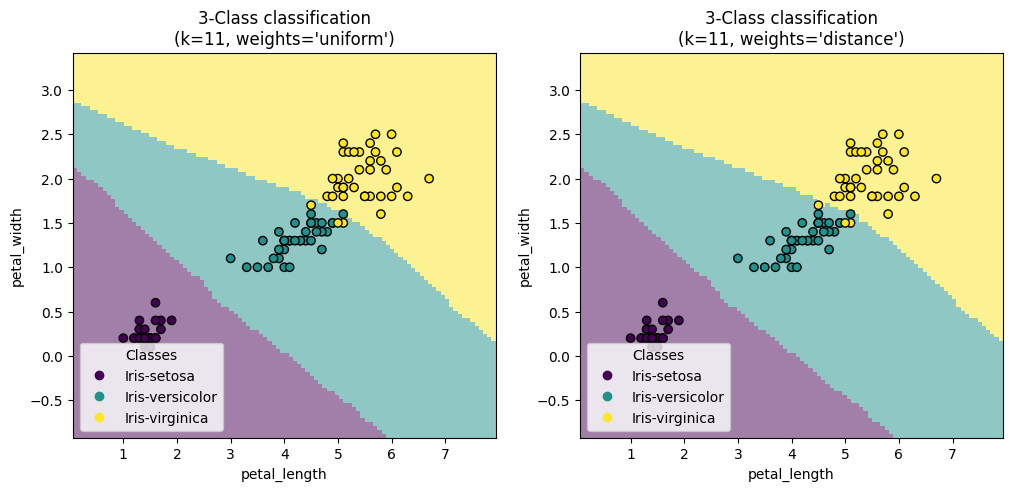

In [8]:
# Ambil dua fitur utama untuk visualisasi decision boundary
feature_columns = ["petal_length", "petal_width"]
# df_cleaned is likely meant to be the DataFrame after outlier removal
# Ensure df_cleaned is the correct DataFrame from previous steps
X = df_cleaned[feature_columns]
y = df_cleaned["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Ubah nama kelas jadi angka

# Membagi data menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Pipeline dengan KNN dan StandardScaler
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Pelatihan model KNN
clf.fit(X_train, y_train)

# Evaluasi model
y_pred = clf.predict(X_test)
print(f"Akurasi: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Visualisasi Decision Boundary
_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=feature_columns[0],
        ylabel=feature_columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(
        X_train.iloc[:, 0], X_train.iloc[:, 1],
        c=y_train, edgecolors="k", cmap="viridis"
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        label_encoder.classes_,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()

Akurasi: 0.8148148148148148
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       0.75      0.43      0.55         7
 Iris-virginica       0.64      0.88      0.74         8

       accuracy                           0.81        27
      macro avg       0.80      0.77      0.76        27
   weighted avg       0.83      0.81      0.80        27



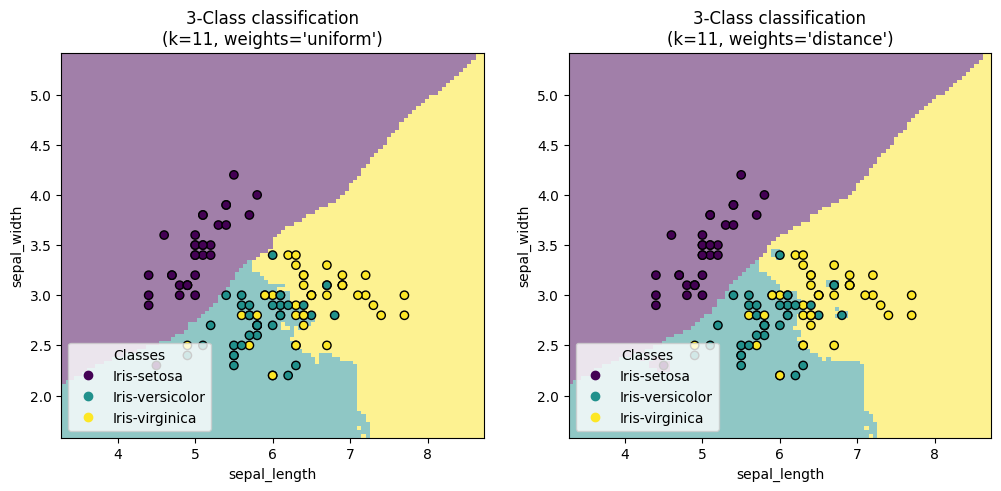

In [9]:
# Ambil dua fitur utama untuk visualisasi decision boundary
feature_columns = ["sepal_length", "sepal_width"]
X = df_merged[feature_columns]
y = df_merged["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Mengubah nama kelas menjadi angka

# Menerapkan LOF untuk deteksi outlier
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outlier_labels = lof.fit_predict(X)
df_merged["outlier"] = outlier_labels

# Menghapus data yang terdeteksi sebagai outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])

# Membagi data menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned[feature_columns],
    label_encoder.transform(df_cleaned["class"]),  # Pastikan target dalam bentuk numerik
    test_size=0.2,
    random_state=42
)

# Pipeline dengan KNN dan StandardScaler
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Pelatihan model KNN
clf.fit(X_train, y_train)

# Evaluasi model
y_pred = clf.predict(X_test)
print(f"Akurasi: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Visualisasi Decision Boundary
_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=feature_columns[0],
        ylabel=feature_columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(
        X_train.iloc[:, 0], X_train.iloc[:, 1],
        c=y_train, edgecolors="k", cmap="viridis"
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        label_encoder.classes_,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()

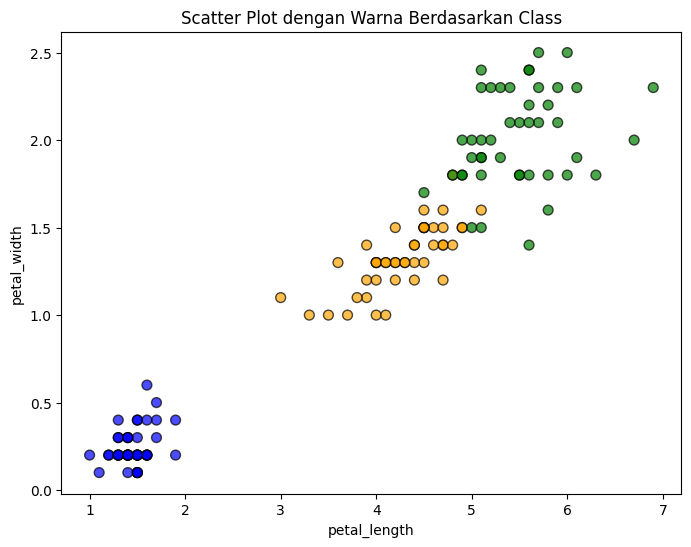

In [10]:
# Pilih dua fitur untuk scatter plot
x_feature = "petal_length"
y_feature = "petal_width"

# Warna berdasarkan kelas
colors = {"Iris-setosa": "blue", "Iris-versicolor": "orange", "Iris-virginica": "green"}
df_cleaned["color"] = df_cleaned["class"].map(colors)

# Plot scatter dengan ukuran (s) dan warna (c)
plt.figure(figsize=(8, 6))
plt.scatter(df_cleaned[x_feature], df_cleaned[y_feature], s=50, c=df_cleaned["color"], alpha=0.7, edgecolors="k")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title("Scatter Plot dengan Warna Berdasarkan Class")
plt.show()

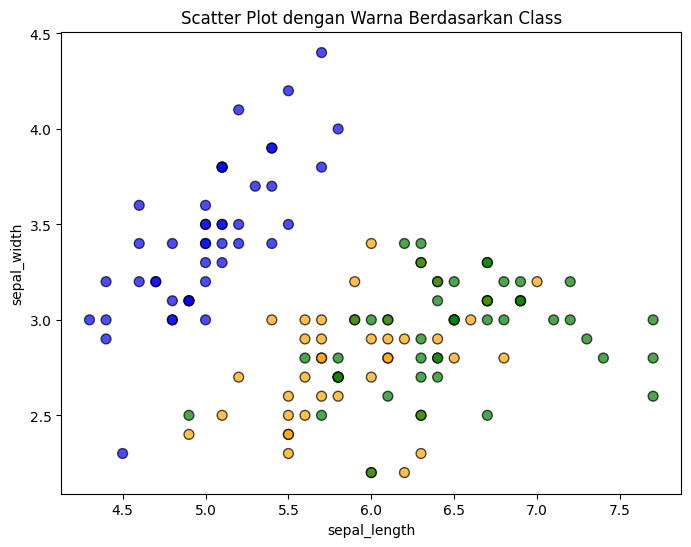

In [11]:
# Pilih dua fitur untuk scatter plot
x_feature = "sepal_length"
y_feature = "sepal_width"

# Warna berdasarkan kelas
colors = {"Iris-setosa": "blue", "Iris-versicolor": "orange", "Iris-virginica": "green"}
df_cleaned["color"] = df_cleaned["class"].map(colors)

# Plot scatter dengan ukuran (s) dan warna (c)
plt.figure(figsize=(8, 6))
plt.scatter(df_cleaned[x_feature], df_cleaned[y_feature], s=50, c=df_cleaned["color"], alpha=0.7, edgecolors="k")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title("Scatter Plot dengan Warna Berdasarkan Class")
plt.show()

## Implemantasi Naive Bayes untuk Klasifikasi Data

Number of mislabeled points with outliers out of a total 30 points : 20
Accuracy with outliers: 33.33%
Mislabeled points with outliers:
Index: 1, True Label: Iris-setosa, Predicted: Iris-versicolor
Index: 2, True Label: Iris-virginica, Predicted: Iris-versicolor
Index: 5, True Label: Iris-setosa, Predicted: Iris-versicolor
Index: 7, True Label: Iris-virginica, Predicted: Iris-versicolor
Index: 10, True Label: Iris-virginica, Predicted: Iris-versicolor
Index: 11, True Label: Iris-setosa, Predicted: Iris-versicolor
Index: 12, True Label: Iris-setosa, Predicted: Iris-versicolor
Index: 13, True Label: Iris-setosa, Predicted: Iris-versicolor
Index: 14, True Label: Iris-setosa, Predicted: Iris-versicolor
Index: 16, True Label: Iris-virginica, Predicted: Iris-versicolor
Index: 19, True Label: Iris-virginica, Predicted: Iris-versicolor
Index: 20, True Label: Iris-setosa, Predicted: Iris-versicolor
Index: 21, True Label: Iris-virginica, Predicted: Iris-versicolor
Index: 22, True Label: Iris-set

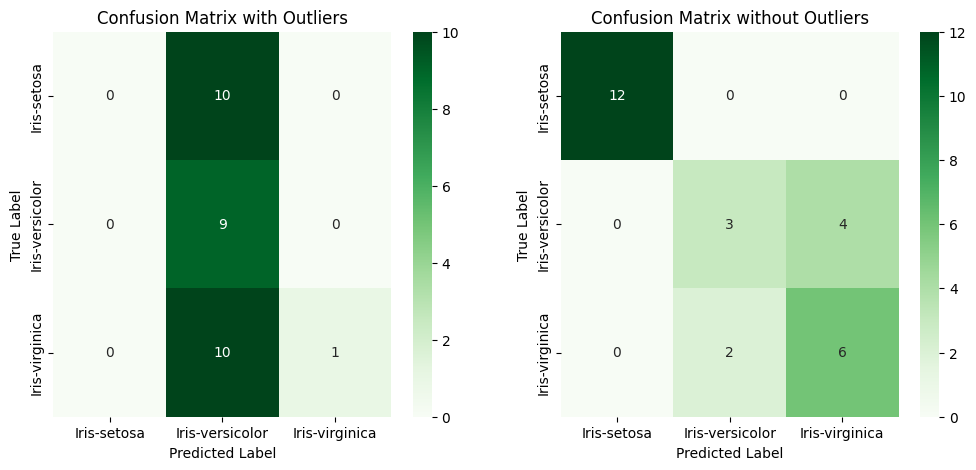

In [15]:
# Asumsikan df_merged sudah ada dari kode sebelumnya

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
df_merged["class_encoded"] = label_encoder.fit_transform(df_merged["class"])

# Data dengan outlier
X_all = df_merged[feature_columns]
y_all = df_merged["class_encoded"].values  # Pastikan dalam bentuk array numpy

# Data tanpa outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])
X_clean = df_cleaned[feature_columns]
y_clean = df_cleaned["class_encoded"].values  # Pastikan dalam bentuk array numpy

# Split data dengan outlier
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42)

# Split data tanpa outlier
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42)

# Inisialisasi model Naive Bayes
gnb = GaussianNB()

# Latih dan uji model dengan outlier
y_pred_all = gnb.fit(X_train_all, y_train_all).predict(X_test_all)
mislabeled_all = (y_test_all != y_pred_all).sum()
accuracy_all = accuracy_score(y_test_all, y_pred_all)
print("Number of mislabeled points with outliers out of a total %d points : %d" % (X_test_all.shape[0], mislabeled_all))
print("Accuracy with outliers: %.2f%%" % (accuracy_all * 100))

# Menampilkan label yang salah pada data dengan outlier
mislabeled_indices_all = np.where(y_test_all != y_pred_all)[0]
print("Mislabeled points with outliers:")
for i in mislabeled_indices_all:
    true_label = label_encoder.inverse_transform([int(y_test_all[i])])[0]
    predicted_label = label_encoder.inverse_transform([int(y_pred_all[i])])[0]
    print(f"Index: {i}, True Label: {true_label}, Predicted: {predicted_label}")
print()
# Latih dan uji model tanpa outlier
y_pred_clean = gnb.fit(X_train_clean, y_train_clean).predict(X_test_clean)
mislabeled_clean = (y_test_clean != y_pred_clean).sum()
accuracy_clean = accuracy_score(y_test_clean, y_pred_clean)
print("Number of mislabeled points without outliers out of a total %d points : %d" % (X_test_clean.shape[0], mislabeled_clean))
print("Accuracy without outliers: %.2f%%" % (accuracy_clean * 100))

# Menampilkan label yang salah pada data tanpa outlier
mislabeled_indices_clean = np.where(y_test_clean != y_pred_clean)[0]
print("Mislabeled points without outliers:")
for i in mislabeled_indices_clean:
    true_label = label_encoder.inverse_transform([int(y_test_clean[i])])[0]
    predicted_label = label_encoder.inverse_transform([int(y_pred_clean[i])])[0]
    print(f"Index: {i}, True Label: {true_label}, Predicted: {predicted_label}")

# Visualisasi Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test_all, y_pred_all), annot=True, fmt="d", cmap="Greens", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title("Confusion Matrix with Outliers")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(confusion_matrix(y_test_clean, y_pred_clean), annot=True, fmt="d", cmap="Greens", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title("Confusion Matrix without Outliers")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.show()